In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [4]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_config
from src.vit_cluster_train import ViTDeepClusterTrainer
from src.vit_data_clustering import ViTDataDeepClustering
from src.vit_data import load_cell_cycle_data
import importlib

config_name = 'deep_clustering_test'
config = importlib.import_module(f"config.{config_name}")

vit = load_model_config(config)
vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM, 
                                init_class=ViTDataDeepClustering, debug_n=None)

In [5]:
times = np.array(sorted(list(set(vit_data.times))))
times

array([  0.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 120.,
       130., 140.])

0

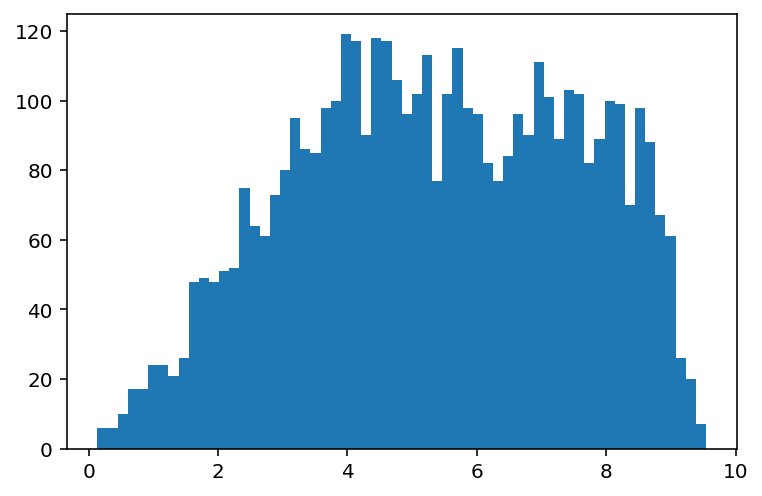

In [10]:
rna_cc = pd.read_csv('data/yulong_cell_cycle_paper_Table_S2_rna.csv').set_index('Gene_ID')
rna_cc = rna_cc.loc[list(set(vit_data.orfs)\
    .intersection(set(rna_cc.index)))].sort_values('Fourier_score', ascending=False)
plt.hist(rna_cc.Fourier_score, bins=60)
0

In [11]:
cc_prom_tf = pd.read_csv('data/yulong_cell_cycle_paper_Table_S2_promoter_TF.csv').set_index('Gene_ID')
cc_prom_tf = cc_prom_tf.loc[list(set(vit_data.orfs)\
    .intersection(set(cc_prom_tf.index)))].sort_values('Fourier_score', ascending=False)
cc_prom_tf.head(2)

,Gene_name,Fourier_score,P_value,FDR
Gene_ID,,,,
YPR119W,CLB2,9.134776,0.00005,0.050818
YNL058C,YNL058C,8.975835,0.00012,0.055900


0

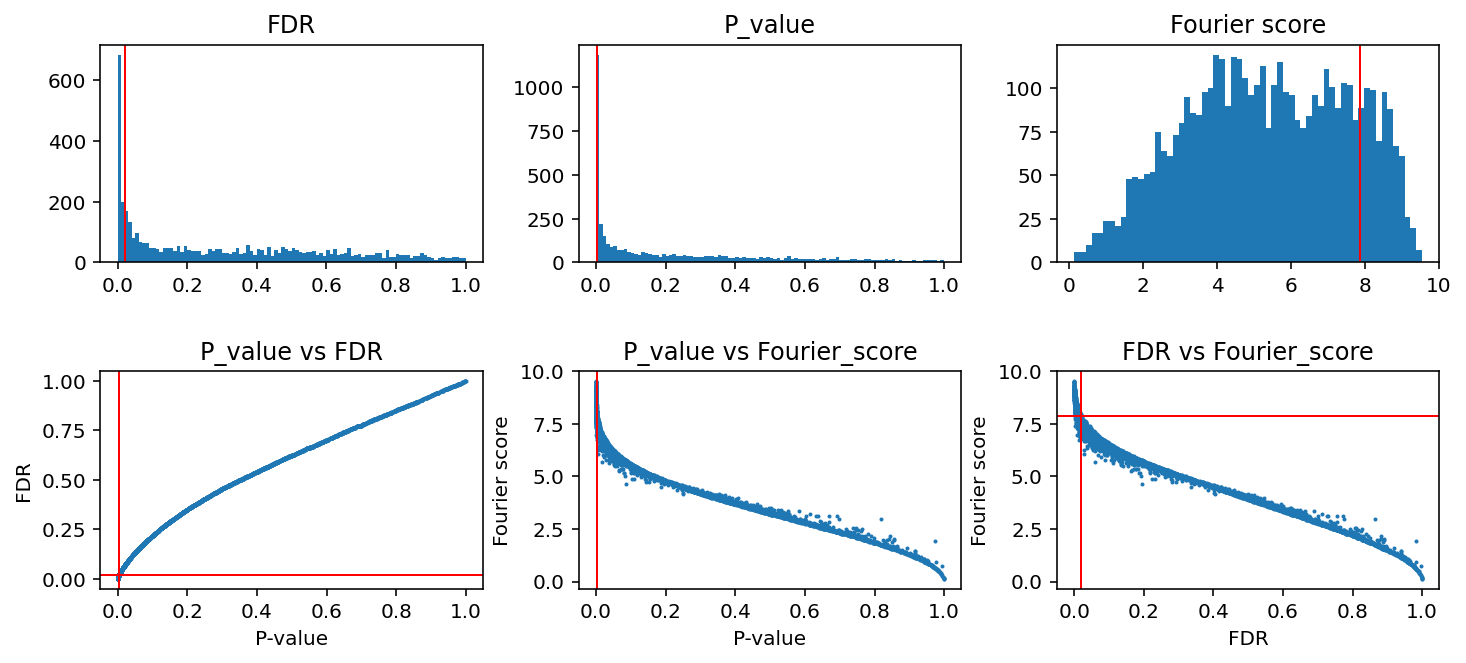

In [12]:
cc_set = rna_cc

fdr_cutoff = 0.02
last_item = cc_set[cc_set['FDR'] < fdr_cutoff].sort_values('FDR').iloc[-1]
p_val_cutoff = last_item.P_value
fourier_cutoff = last_item.Fourier_score

fig = plt.figure(figsize=(12, 5))
fig.tight_layout(rect=[0.0, 0., 1.0, 0.8])
plt.subplots_adjust(hspace=0.5, wspace=0.25)
    
plt.subplot(2, 3, 1)
plt.hist(cc_set.FDR, bins=100)
plt.axvline(fdr_cutoff, lw=1, c='red')
plt.title("FDR")

plt.subplot(2, 3, 2)
plt.hist(cc_set.P_value, bins=100)
plt.axvline(p_val_cutoff, lw=1, c='red')
plt.title("P_value")

plt.subplot(2, 3, 3)
plt.hist(cc_set.Fourier_score, bins=60)
plt.axvline(fourier_cutoff, lw=1, c='red')
plt.title("Fourier score")

plt.subplot(2, 3, 4)
plt.scatter(cc_set.P_value, cc_set.FDR, s=1)
plt.axvline(p_val_cutoff, lw=1, c='red')
plt.axhline(fdr_cutoff, lw=1, c='red')
plt.title("P_value vs FDR")
plt.xlabel('P-value')
plt.ylabel('FDR')

plt.subplot(2, 3, 5)
plt.scatter(cc_set.P_value, cc_set.Fourier_score, s=1)
plt.axvline(p_val_cutoff, lw=1, c='red')
plt.title("P_value vs Fourier_score")
plt.xlabel('P-value')
plt.ylabel('Fourier score')

plt.subplot(2, 3, 6)
plt.scatter(cc_set.FDR, cc_set.Fourier_score, s=1)
plt.axvline(fdr_cutoff, lw=1, c='red')
plt.axhline(fourier_cutoff, lw=1, c='red')
plt.xlabel('FDR')
plt.ylabel('Fourier score')
plt.title("FDR vs Fourier_score")
0


In [13]:
orf_names = vit_data.read_log_tpm_data().index.values
len(orf_names)

4427

In [14]:
cc_dat = pd.DataFrame(index=orf_names).join(cc_set, how='left')
cc_dat['idx'] = np.arange(len(cc_dat))
cc_dat.head(2)

,Gene_name,Fourier_score,P_value,FDR,Cell_cycle_phase,idx
YAL063C,FLO9,4.263286,0.28523,0.438953,NaN,0
YAL062W,GDH3,2.074419,0.77236,0.830606,NaN,1


In [15]:
cell_cycle_genes_rna = cc_dat[cc_dat.FDR < fdr_cutoff]
len(cell_cycle_genes_rna)

881

In [16]:
cc_idx = cell_cycle_genes_rna.idx.values

In [17]:
imgs = vit_data.all_imgs

In [18]:
from src.attention_analysis import pivot_images

pivoted_images = pivot_images(imgs, times)

In [19]:
import cv2
from src.timer import Timer

timer = Timer()

att_size = (3, 16)
imgs_resized = np.zeros((len(vit_data), 2, att_size[0], att_size[1]))

for i in range(len(vit_data.all_imgs)):
    cur_img = vit_data.all_imgs[i]
    for channel in range(cur_img.shape[0]):
        img_resize = cv2.resize(cur_img[channel], (att_size[1], att_size[0]))
        imgs_resized[i, channel] = img_resize
    timer.print_progress(i, len(vit_data.all_imgs), every=20000)


0/57551 - 00:00:00.01
20000/57551 - 00:00:00.23
40000/57551 - 00:00:00.46


In [20]:
from src.utils import write_pickle

#write_pickle(imgs_resized, 'data/vit/cell_cycle_24x128_p1/resized_imgs_all.pkl')


In [21]:
resize_pivoted = pivot_images(imgs_resized, times)
resize_pivoted.shape

(4427, 2, 13, 3, 16)

In [22]:
# Store the score itself and the period (in minutes) as the second dimension
fourier_scores = np.zeros((resize_pivoted.shape[0], 2, resize_pivoted.shape[1],
                           resize_pivoted.shape[3], resize_pivoted.shape[4]))


In [23]:
fourier_scores.shape

(4427, 2, 2, 3, 16)

In [361]:
times

array([  0.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 120.,
       130., 140.])

In [370]:
from src.timer import Timer
from src.attention_analysis import fourier_score

timer = Timer()

for idx in range(resize_pivoted.shape[0]):
    for channel in range(resize_pivoted.shape[1]):
        for i in range(resize_pivoted.shape[3]):
            for j in range(resize_pivoted.shape[4]):
                vals = resize_pivoted[idx, channel, :, i, j]
                new_vals = vals
                score, offset = fourier_score(new_vals[1:], times[1:], period=63, highest_offset=140)
                fourier_scores[idx, :, channel, i, j] = np.array([score, offset])
    timer.print_progress(idx, resize_pivoted.shape[0], every=1000)

0/4427 - 00:00:00.28
1000/4427 - 00:04:35.34
2000/4427 - 00:09:07.79
3000/4427 - 00:13:45.19
4000/4427 - 00:18:17.71


(array([  56.,  236.,  162.,  110., 3084.,  207.,  109.,  218.,  131.,
         114.]),
 array([ 11. ,  23.8,  36.6,  49.4,  62.2,  75. ,  87.8, 100.6, 113.4,
        126.2, 139. ]),
 <BarContainer object of 10 artists>)

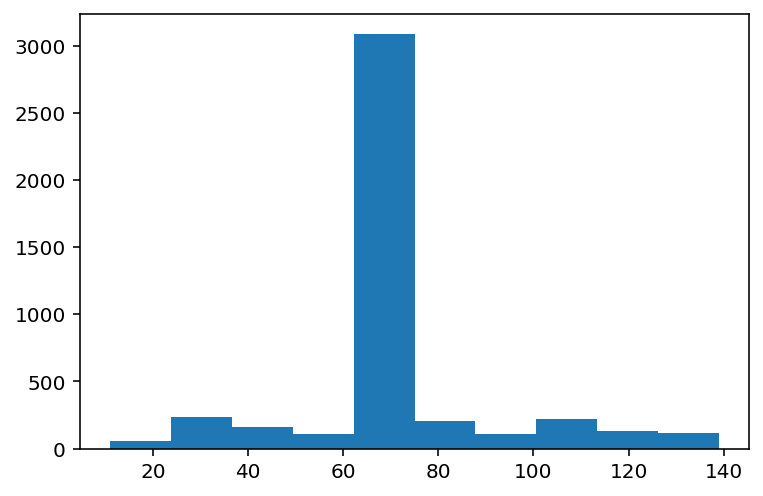

In [372]:
plt.hist(fourier_scores[:, 1, 0, 2, 8])

In [32]:
max_f_scores = fourier_scores.max(axis=-1).max(axis=-1).max(axis=-1)[:, 0]
sorted_f_indices = max_f_scores.argsort()

In [33]:
mean_occ = resize_pivoted.mean(axis=1).mean(axis=1).mean(axis=1).mean(axis=1)
sorted_mean_indices = mean_occ.argsort()

In [34]:
cc_dat['max_chrom_f_scores'] = max_f_scores
cc_dat['mean_occ'] = mean_occ

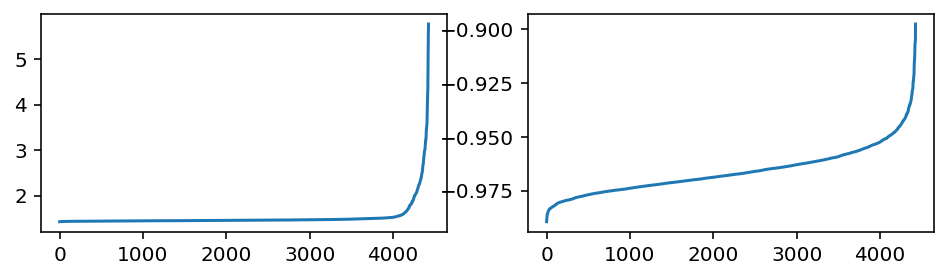

In [35]:

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(max_f_scores[sorted_f_indices])

plt.subplot(1, 2, 2)
plt.plot(mean_occ[sorted_mean_indices])


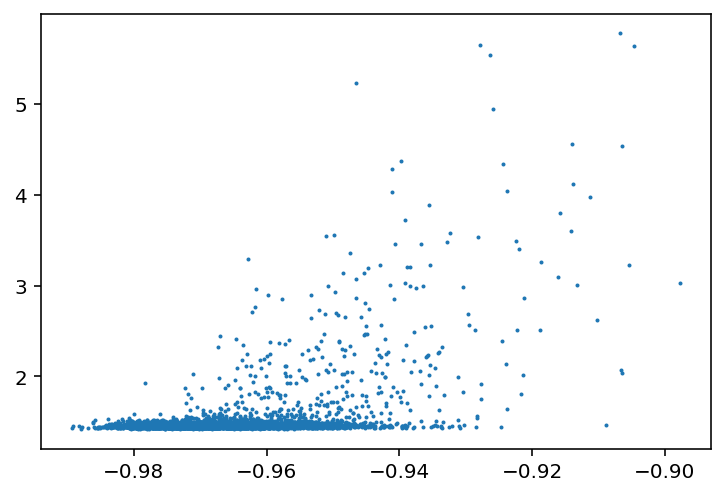

In [36]:
plt.scatter(mean_occ, max_f_scores, s=1)

(array([96.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0., 46.]),
 array([ 0.79245589,  4.7132103 ,  8.63396471, 12.55471912, 16.47547354,
        20.39622795, 24.31698236, 28.23773677, 32.15849118, 36.07924559,
        40.        ]),
 <BarContainer object of 10 artists>)

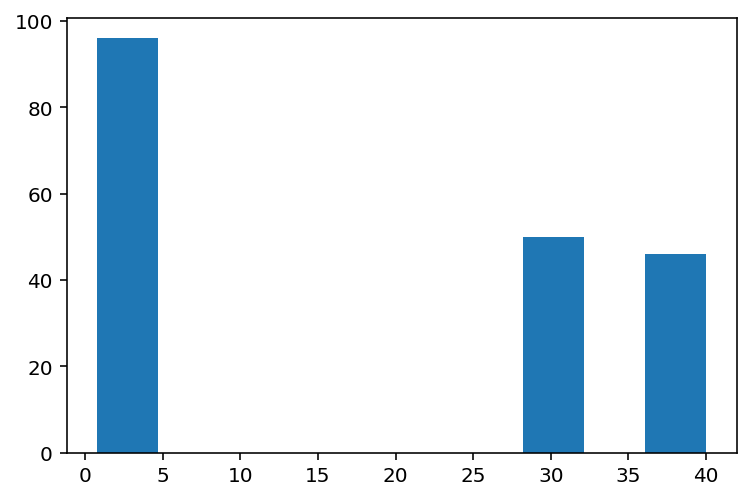

In [39]:
plt.hist(fourier_scores[idx].flatten())

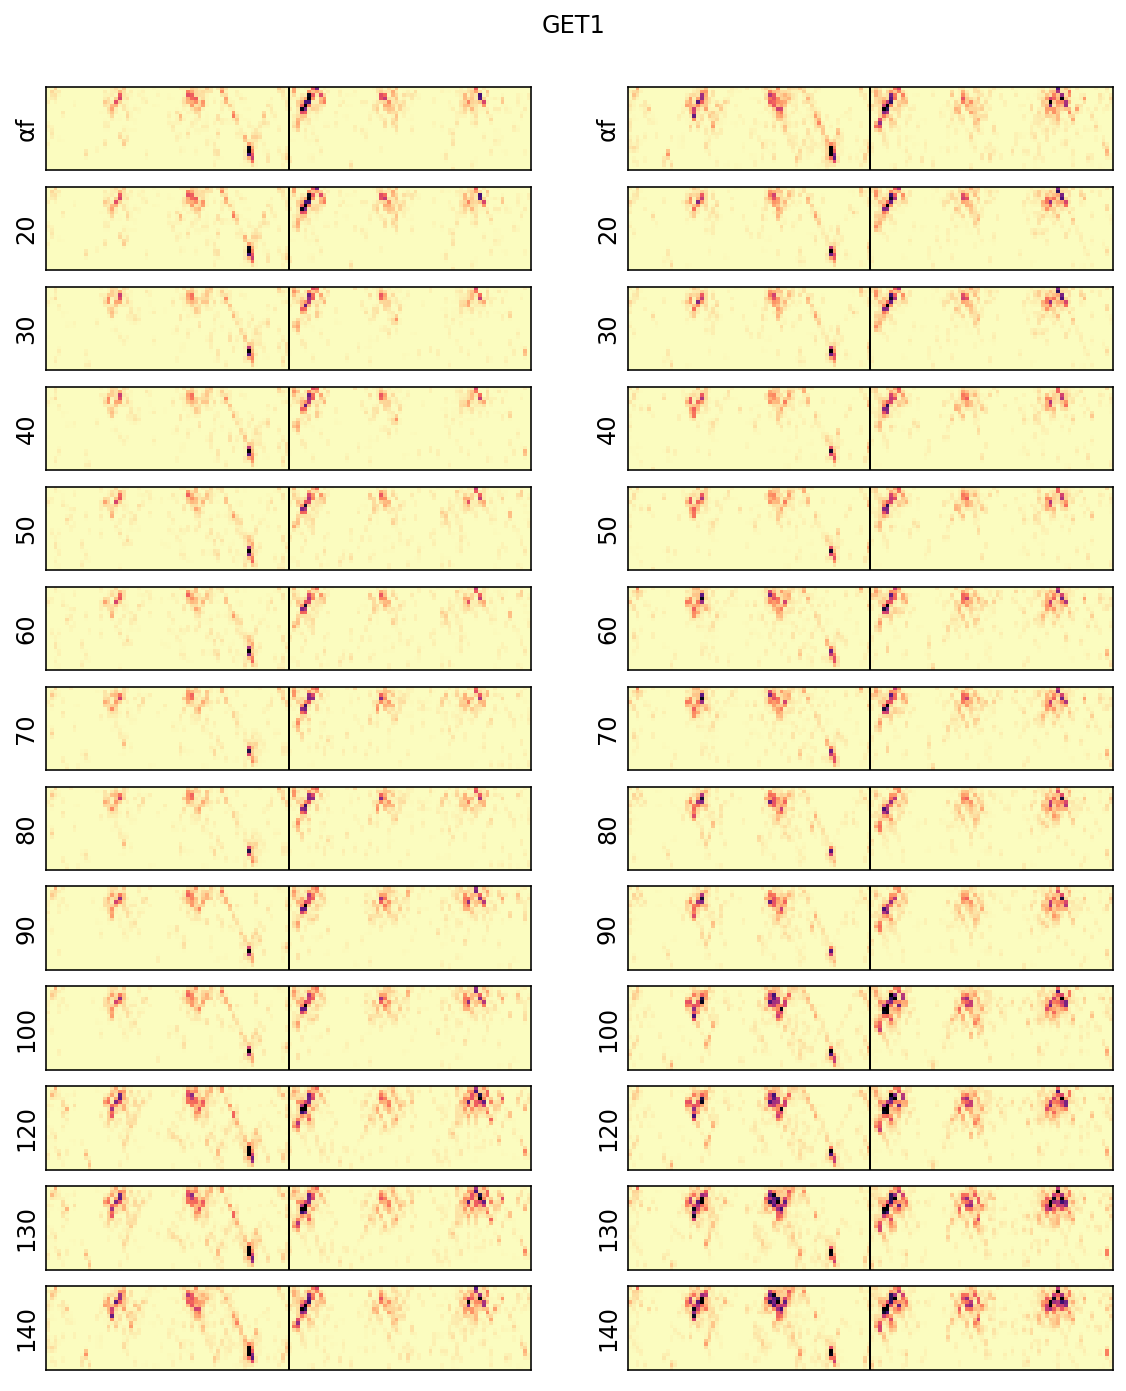

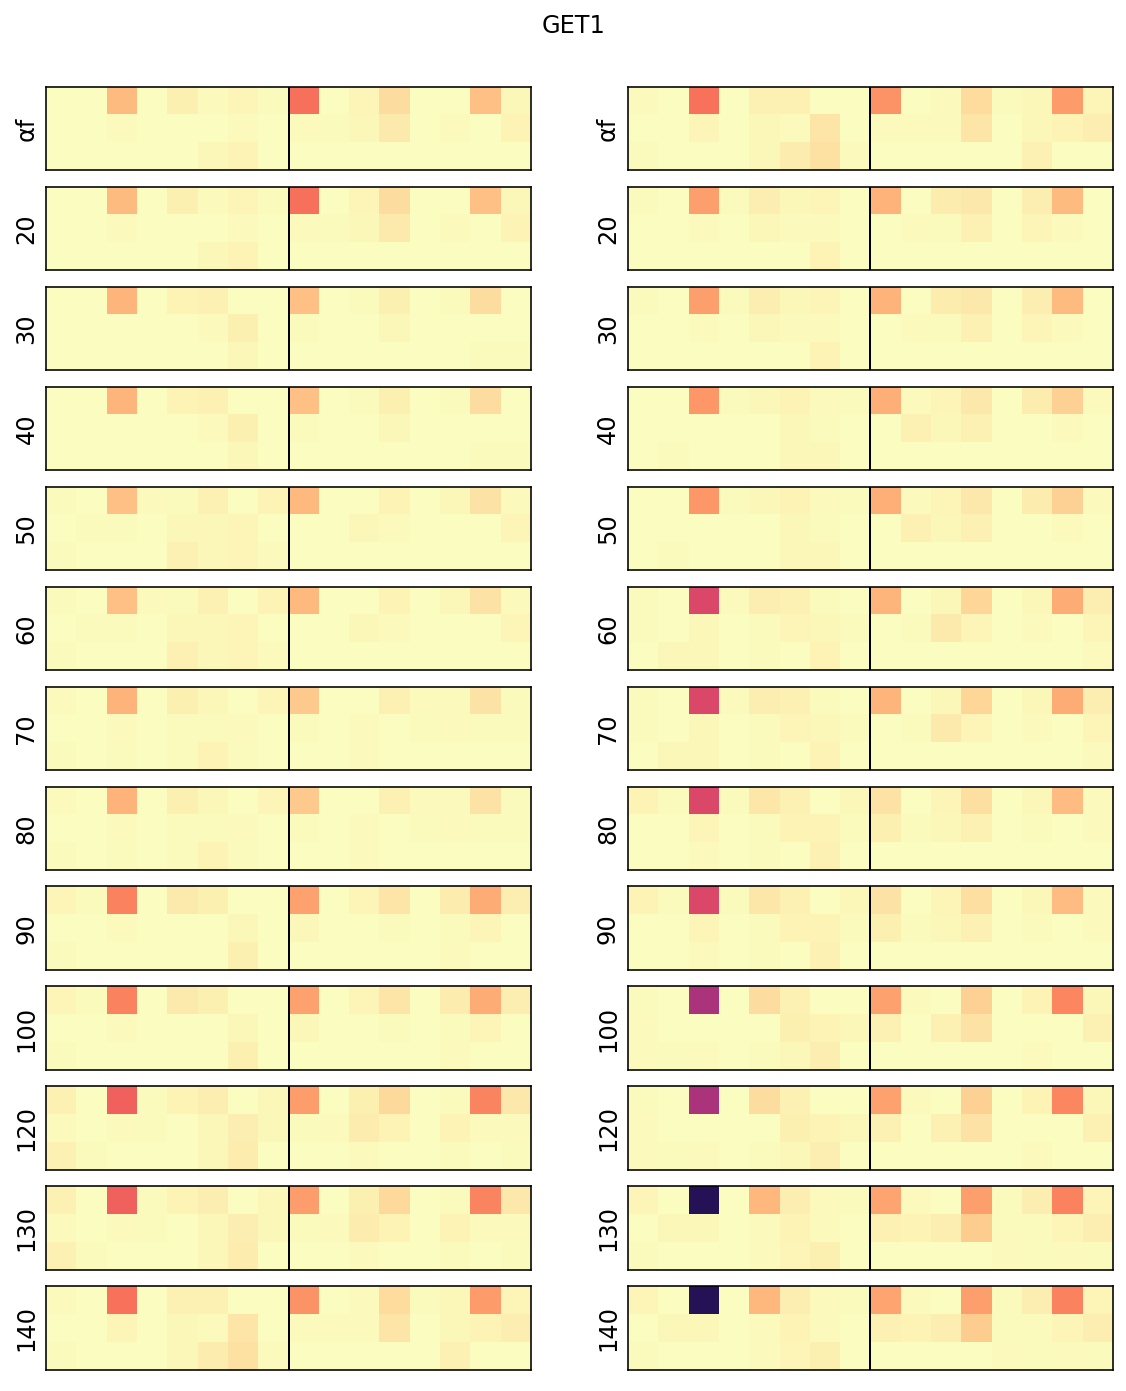

In [40]:
from src.attention_analysis import plot_typhoon
genes = ['GET1']
    
for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, pivoted_images, vmin=-1, vmax=0)
    
for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, resize_pivoted, vmin=-1, vmax=0)
    

In [41]:
resize_pivoted.shape

(4427, 2, 13, 3, 16)

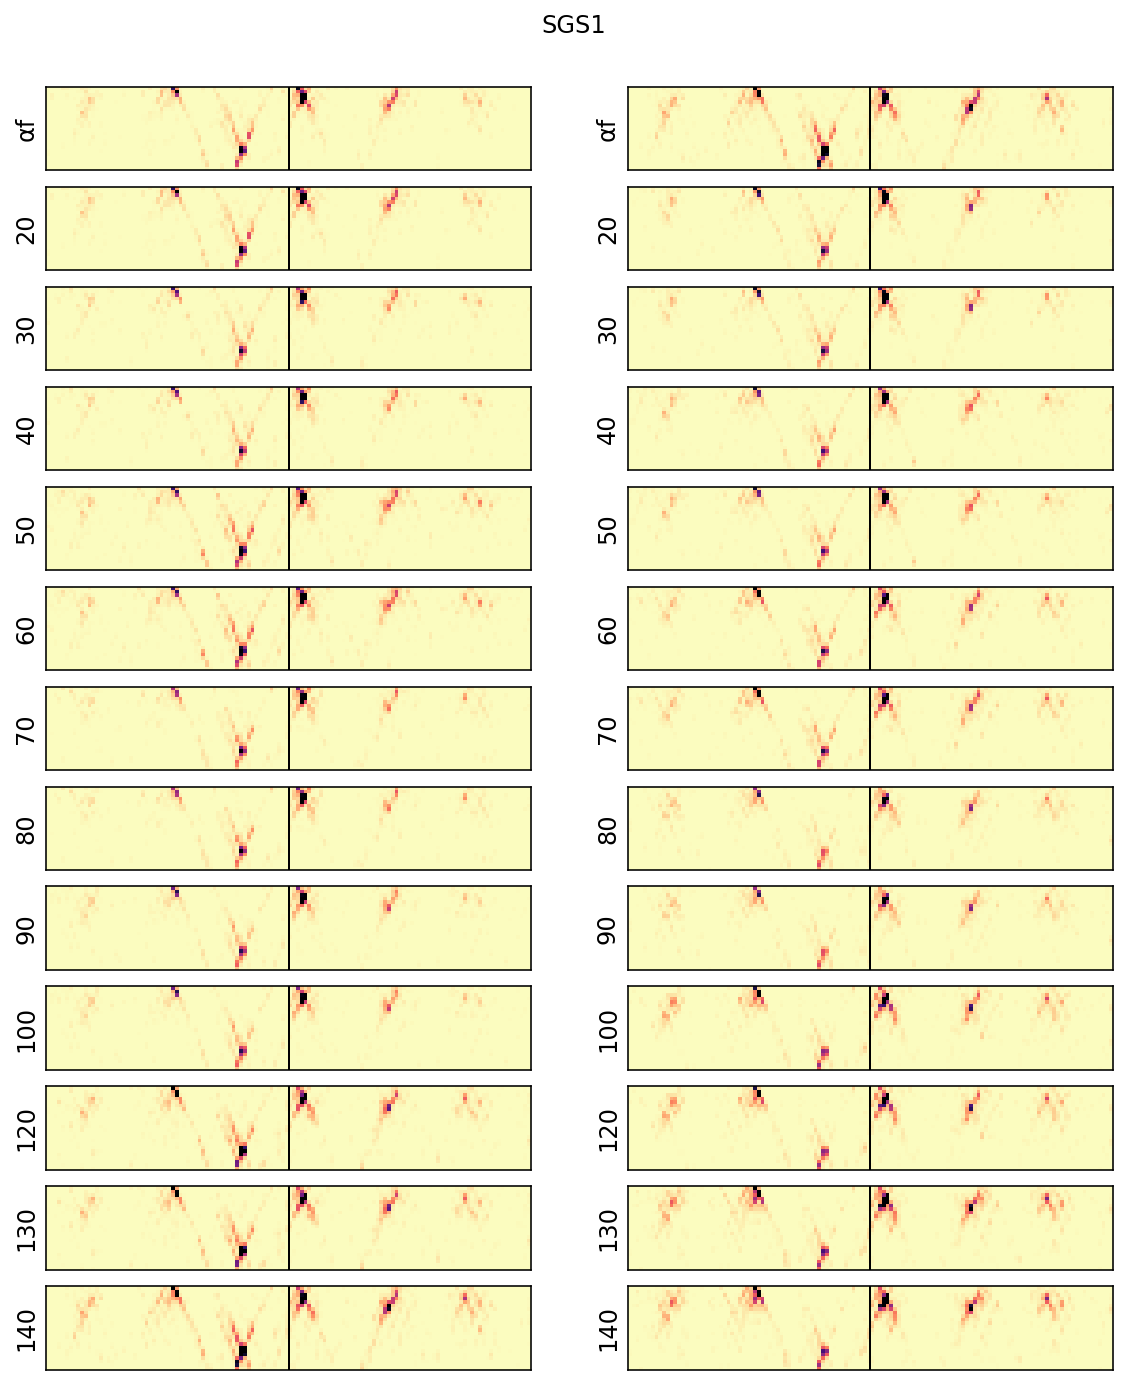

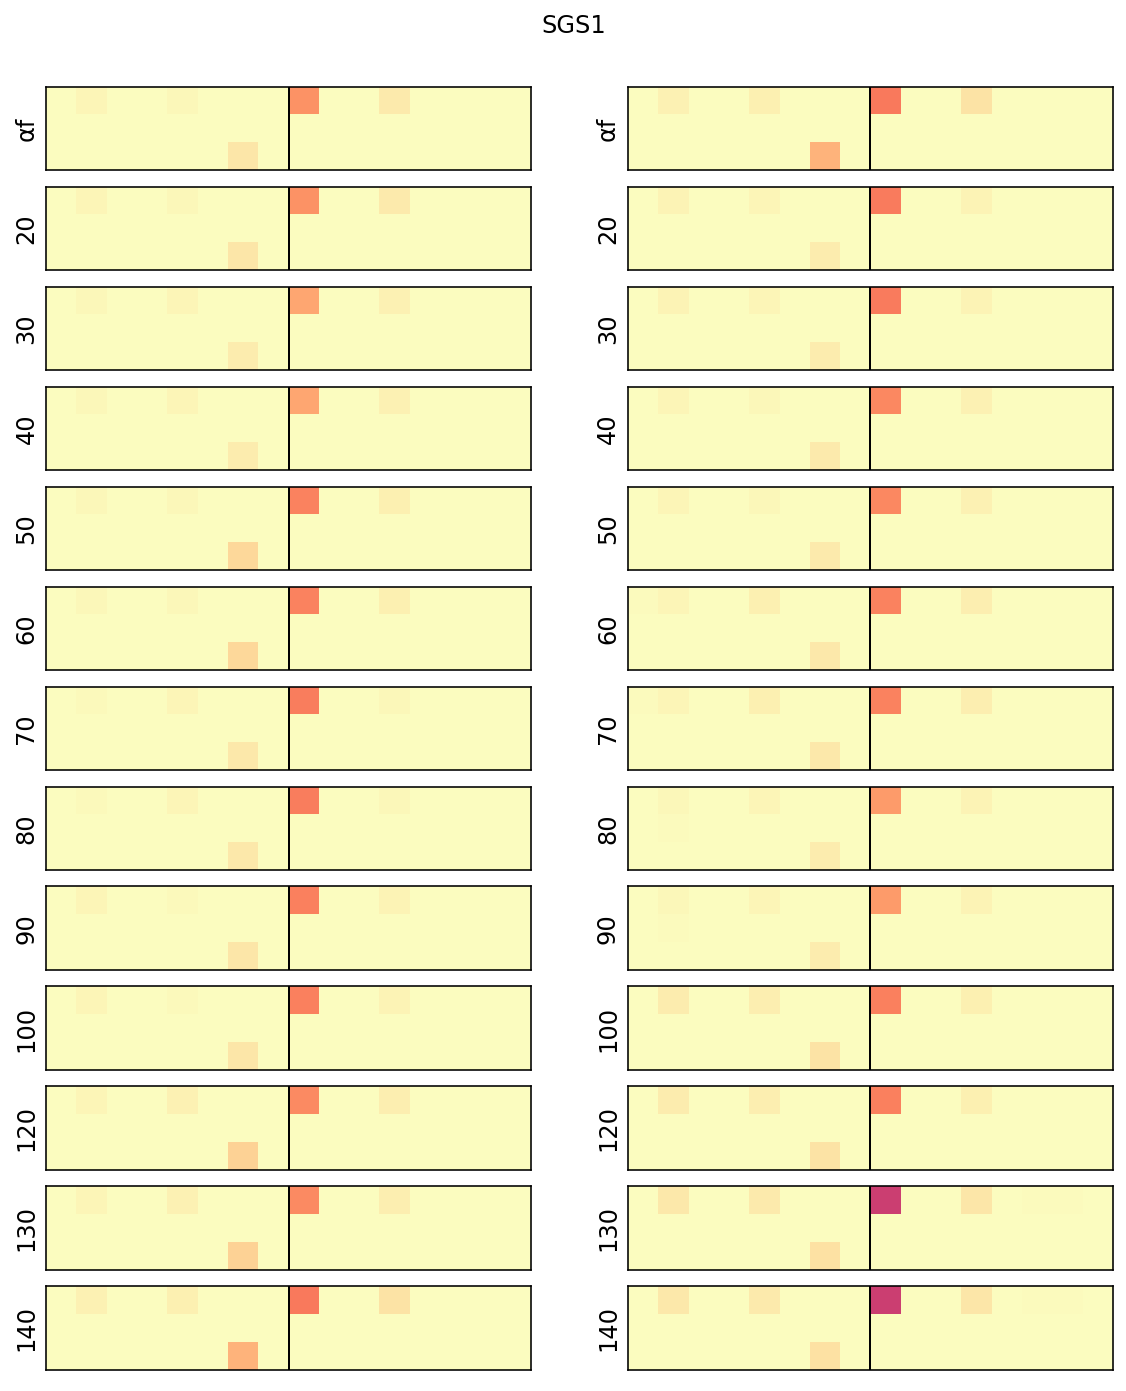

In [42]:
from src.attention_analysis import plot_typhoon
genes = ['SGS1']
    
for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, pivoted_images, vmin=-1, vmax=1)
    
for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, resize_pivoted, vmin=-1, vmax=10)
    

0

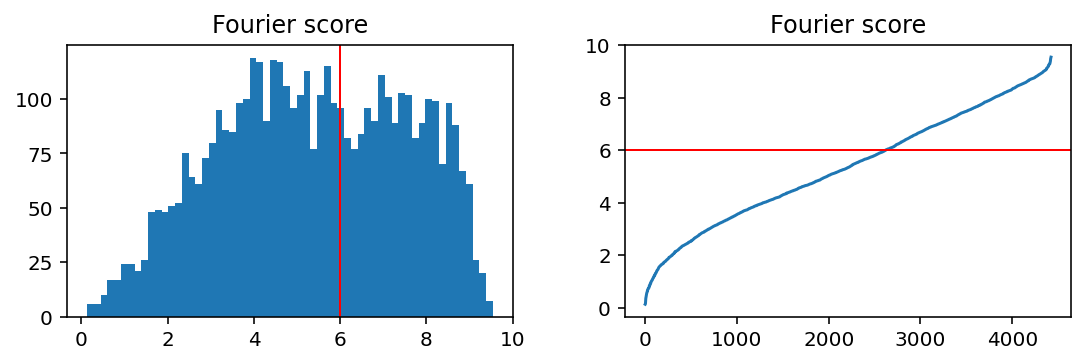

In [43]:
cc_set = rna_cc

fourier_cutoff = 6

fig = plt.figure(figsize=(9, 2.5))
fig.tight_layout(rect=[0.0, 0., 1.0, 0.8])
plt.subplots_adjust(hspace=0.5, wspace=0.25)

plt.subplot(1, 2, 1)
plt.hist(cc_set.Fourier_score, bins=60)
plt.axvline(fourier_cutoff, lw=1, c='red')
plt.title("Fourier score")

plt.subplot(1, 2, 2)
plt.plot(list(reversed(cc_set.Fourier_score.values)))
plt.axhline(fourier_cutoff, lw=1, c='red')
plt.title("Fourier score")

0

In [44]:
rna_cutoff = 6
chrom_cutoff = 1.6
chrom_occ_cutoff = 0.035 - 1

cell_cycling_genes = cc_dat[(cc_dat.Fourier_score > rna_cutoff) & 
       (cc_dat.max_chrom_f_scores > chrom_cutoff) &
       (cc_dat.mean_occ > chrom_occ_cutoff)]

cell_cycling_genes = cell_cycling_genes.sort_values('max_chrom_f_scores')
cell_cycling_genes = cell_cycling_genes[-100:]

len(cell_cycling_genes)

100

In [45]:
rna_cutoff = 4
chrom_cutoff = 1.55
chrom_occ_cutoff = 0.04 - 1

non_cell_cycling_genes = cc_dat[(cc_dat.Fourier_score < rna_cutoff) & 
       (cc_dat.max_chrom_f_scores < chrom_cutoff) &
       (cc_dat.mean_occ > chrom_occ_cutoff)]

non_cell_cycling_genes = non_cell_cycling_genes.sort_values('max_chrom_f_scores')
non_cell_cycling_genes = non_cell_cycling_genes[:100]
len(non_cell_cycling_genes)

100

Text(0, 0.5, 'Fourier score')

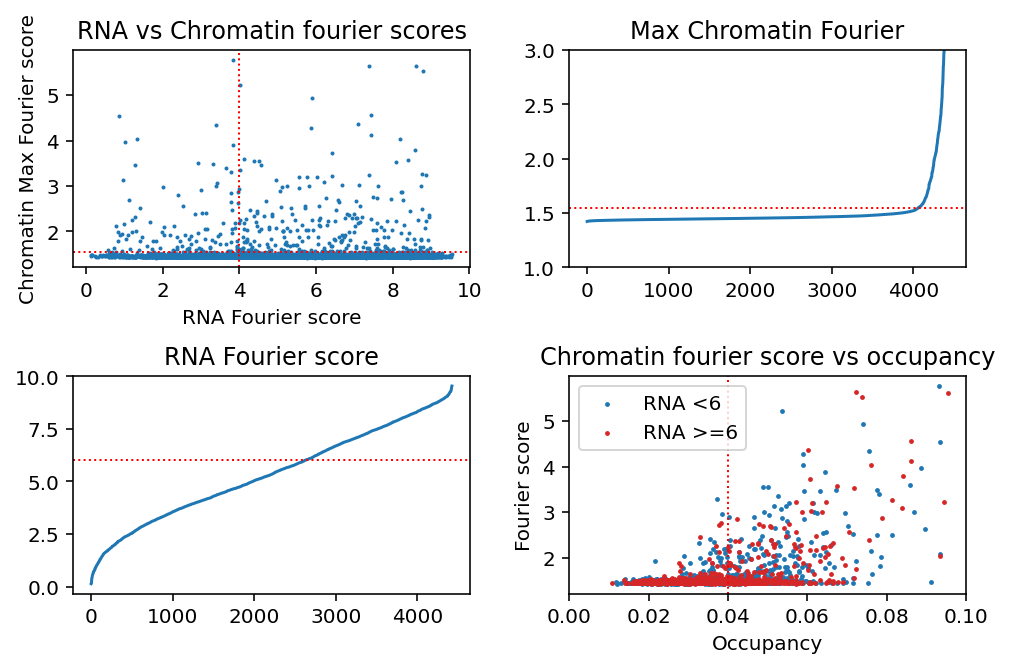

In [46]:
fig = plt.figure(figsize=(8, 5))
fig.tight_layout(rect=[0.0, 0., 1.0, 0.8])
plt.subplots_adjust(hspace=0.5, wspace=0.25)

plt.subplot(2, 2, 1)

plt.scatter(cc_dat.Fourier_score, cc_dat.max_chrom_f_scores, s=1)
plt.xlabel('RNA Fourier score')
plt.ylabel('Chromatin Max Fourier score')
plt.title("RNA vs Chromatin fourier scores")

cutoffs = rna_cutoff, chrom_cutoff
plt.axvline(cutoffs[0], c='red', linestyle='dotted', lw=1)
plt.axhline(cutoffs[1], c='red', linestyle='dotted', lw=1)

plt.subplot(2, 2, 2)
plt.plot(cc_dat.sort_values('max_chrom_f_scores').max_chrom_f_scores.values)
plt.axhline(cutoffs[1], c='red', linestyle='dotted', lw=1)
plt.ylim(1, 3)
plt.title("Max Chromatin Fourier")

plt.subplot(2, 2, 3)
plt.plot(list(reversed(cc_set.Fourier_score.values)))
plt.axhline(fourier_cutoff, lw=1, c='red', linestyle='dotted')
plt.title("RNA Fourier score")

len(cc_dat[(cc_dat.Fourier_score > cutoffs[0]) & (cc_dat.max_chrom_f_scores > cutoffs[1])])

plt.subplot(2, 2, 4)
plt_data = cc_dat[cc_dat.Fourier_score < 6]
plt.scatter(plt_data.mean_occ.values+1, plt_data.max_chrom_f_scores.values, 
            s=2, label="RNA <6")
plt_data = cc_dat[cc_dat.Fourier_score >= 6]
plt.scatter(plt_data.mean_occ.values+1, plt_data.max_chrom_f_scores.values, 
            s=2, label="RNA >=6", color=plt.get_cmap('tab10')(3))
plt.axvline(chrom_occ_cutoff+1, lw=1, c='red', linestyle='dotted')
plt.legend()

plt.xlim(0, 0.1)
plt.title("Chromatin fourier score vs occupancy")
plt.xlabel("Occupancy")
plt.ylabel("Fourier score")


In [47]:
cc_dat['label'] = 'unlabeled'
cc_dat.loc[non_cell_cycling_genes.index.values, 'label'] = 'non_cell_cycle'
cc_dat.loc[cell_cycling_genes.index.values, 'label'] = 'cell_cycle'

In [48]:
cc_idx = cc_dat[cc_dat.label == 'cell_cycle'].idx.values
non_cc_idx = cc_dat[cc_dat.label == 'non_cell_cycle'].idx.values

In [49]:
cc_dat.sort_values('idx').reset_index().rename(columns={'index': 'orf_name'})\
    .to_csv('data/yulong_RNA_fourier_plus_cell_cycling_label_chrom_fourier.csv', index=False)

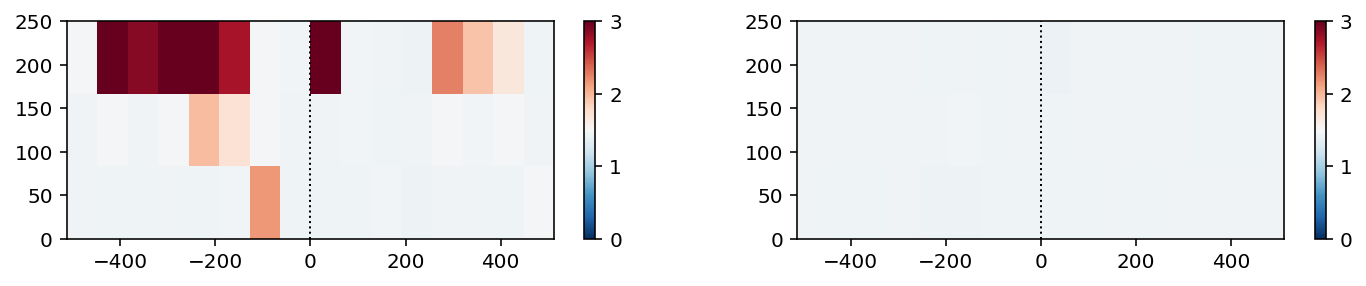

In [50]:
plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.imshow(fourier_scores[cc_idx, 0, 0].max(axis=0), cmap='RdBu_r', extent=[-512, 512, 0, 250], 
           aspect='auto', origin='lower', vmin=0, vmax=3)
plt.axvline(0, c='black', linestyle='dotted', lw=1)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(fourier_scores[non_cc_idx, 0, 0].max(axis=0), cmap='RdBu_r', extent=[-512, 512, 0, 250],
           aspect='auto', origin='lower', vmin=0, vmax=3)
plt.axvline(0, c='black', linestyle='dotted', lw=1)
plt.colorbar()

Text(0.5, 1.0, 'Fourier scores (flattened)')

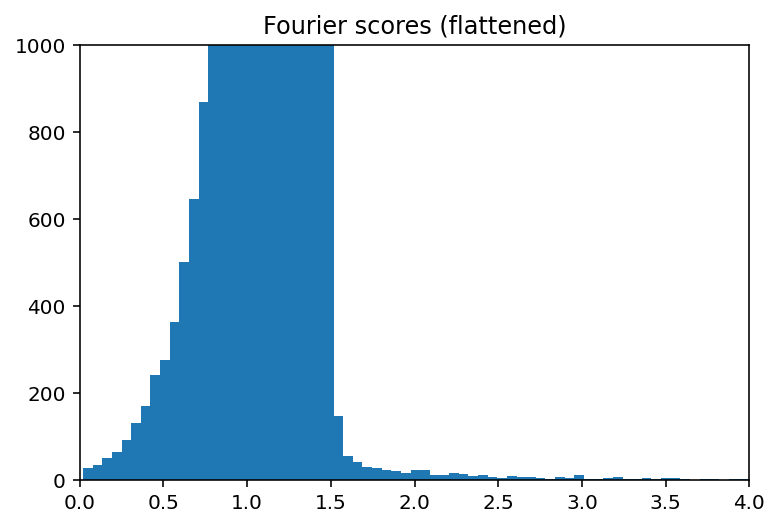

In [51]:
plt.hist(fourier_scores[:, 0].flatten(), bins=100)
plt.xlim(0, 4)
plt.ylim(0, 1000)
plt.title("Fourier scores (flattened)")


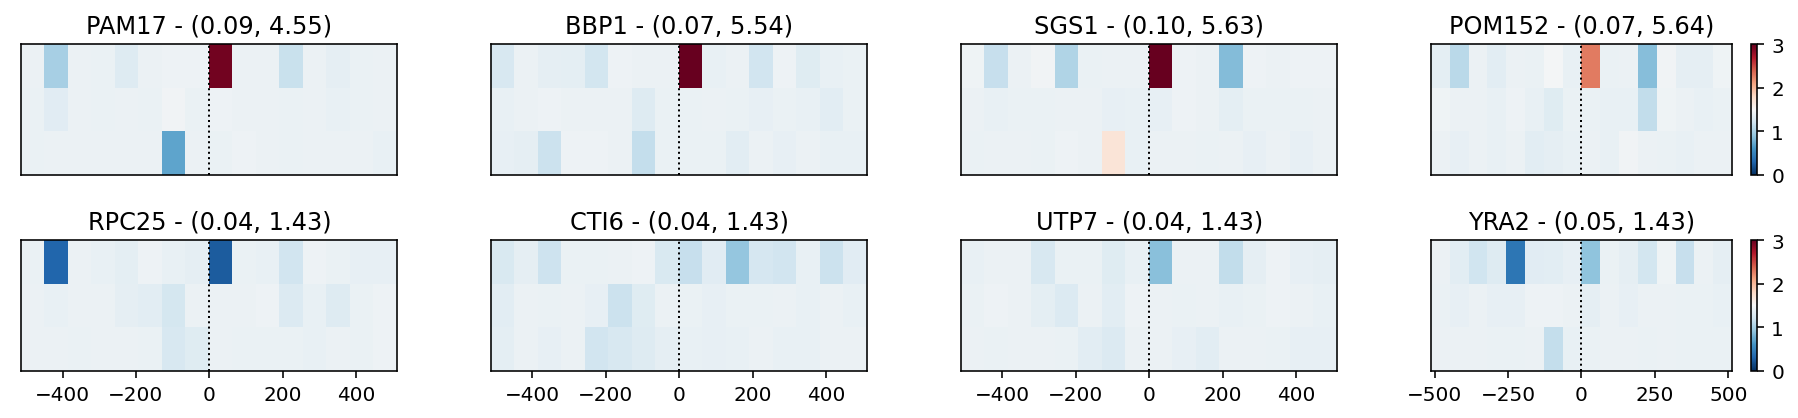

In [52]:
i = 1
num_examples = 4

fig = plt.figure(figsize=(16, 3))
fig.tight_layout(rect=[0.0, 0., 1.0, 0.8])
plt.subplots_adjust(hspace=0.5, wspace=0.25)

plt_data = cc_dat.sort_values('max_chrom_f_scores')

for orf_name, row in plt_data[plt_data.label == 'cell_cycle'].tail(num_examples).iterrows():
    idx = row.idx
    gene_name = row['Gene_name']
    plt.subplot(2, num_examples, i)
    plt.imshow(fourier_scores[idx, 0, 0], origin='lower', extent=[-512, 512, 0, 250], 
               aspect='auto', vmin=0, vmax=3, cmap='RdBu_r')
    plt.axvline(0, c='black', lw=1, linestyle='dotted')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{gene_name} - ({row.mean_occ+1:0.2f}, {row.max_chrom_f_scores:0.2f})")
    i+=1
plt.colorbar()

for orf_name, row in plt_data[plt_data.label == 'non_cell_cycle'].head(num_examples).iterrows():
    idx = row.idx
    gene_name = row['Gene_name']
    plt.subplot(2, num_examples, i)
    plt.imshow(fourier_scores[idx, 0, 0], origin='lower', extent=[-512, 512, 0, 250], 
               aspect='auto', vmin=0, vmax=3, cmap='RdBu_r')
    plt.axvline(0, c='black', lw=1, linestyle='dotted')
    plt.yticks([])
    plt.title(f"{gene_name} - ({row.mean_occ+1:0.2f}, {row.max_chrom_f_scores:0.2f})")
    i+=1
    
plt.colorbar()

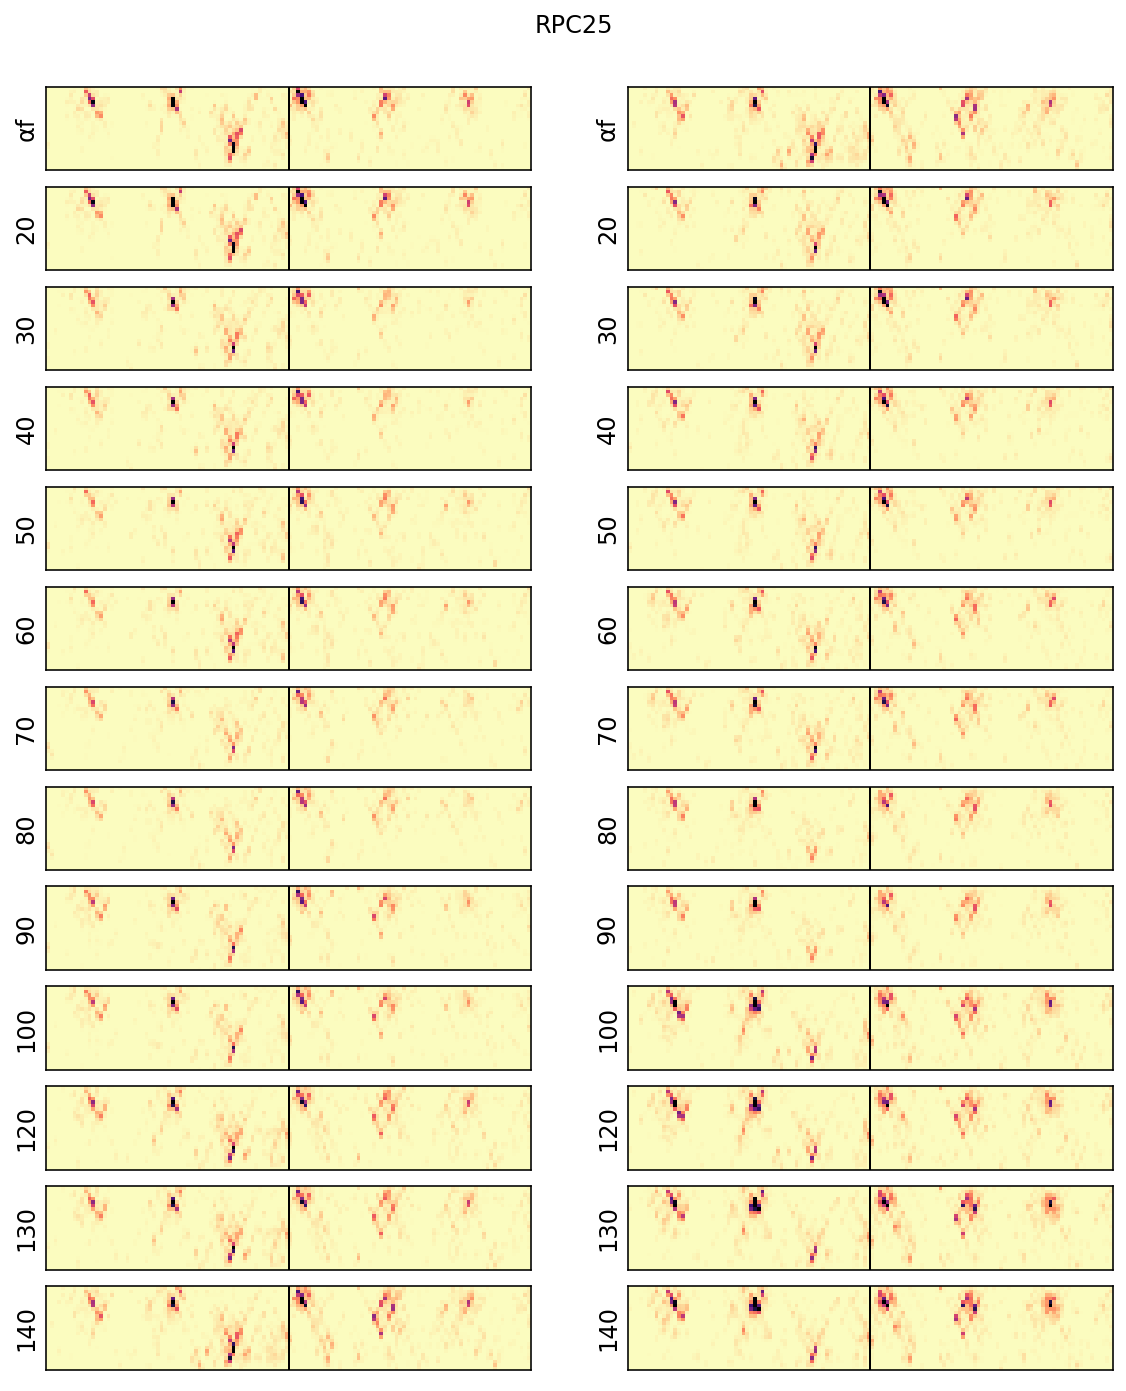

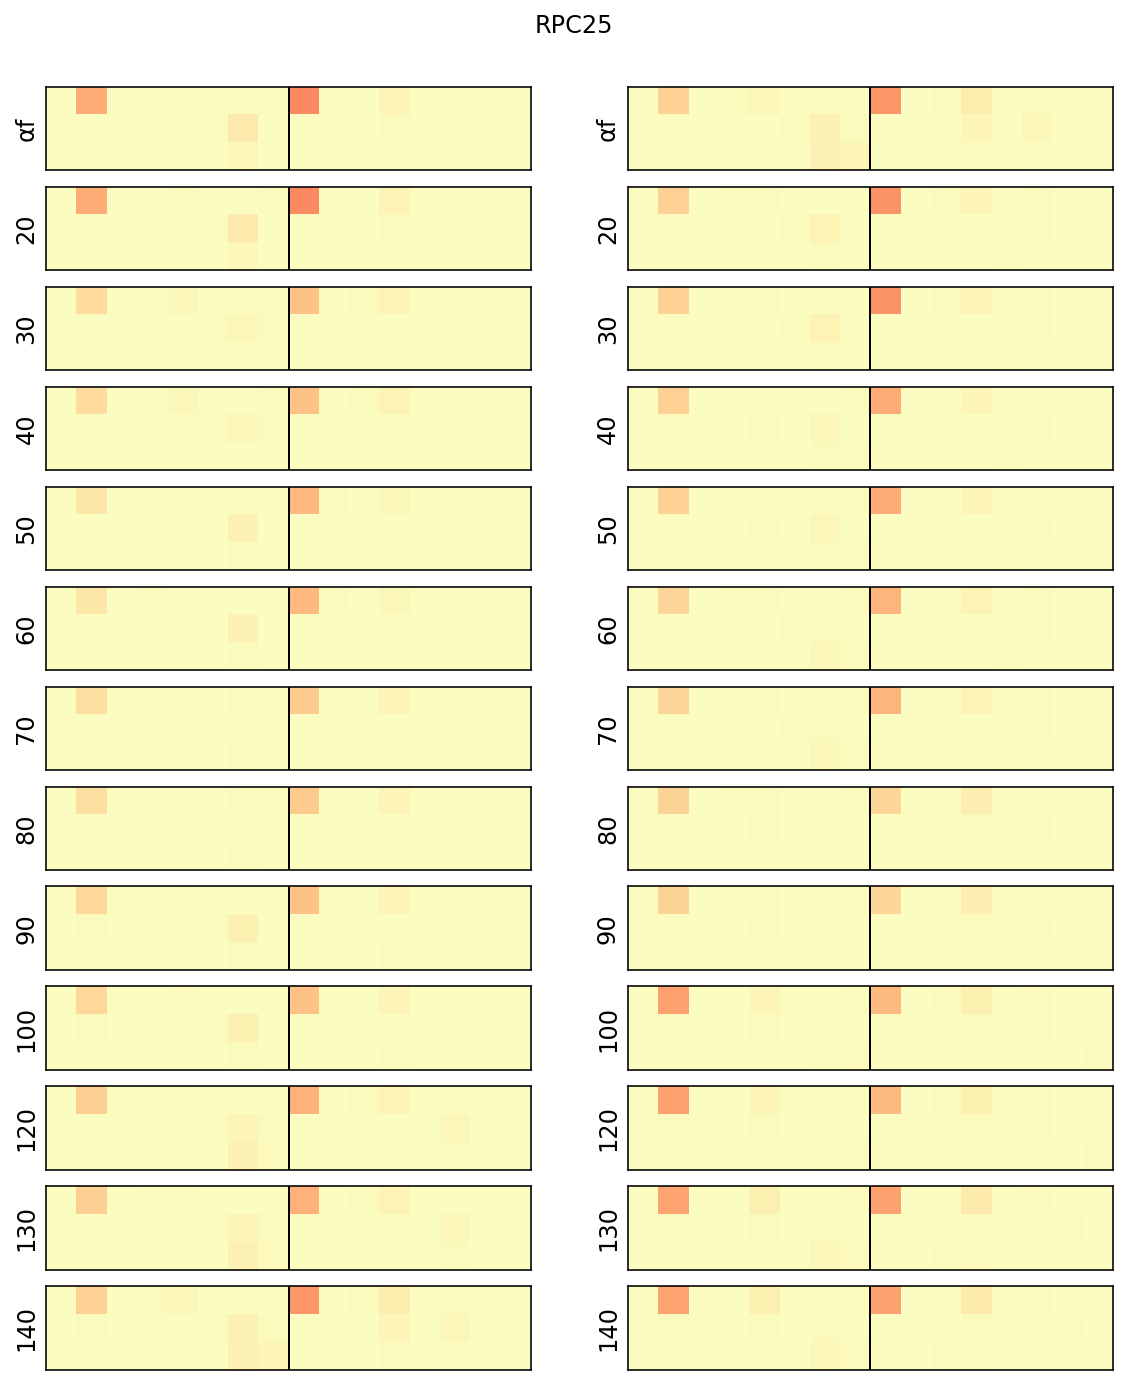

In [53]:
from src.attention_analysis import plot_typhoon
genes = ['RPC25']

for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, pivoted_images, vmin=-1, vmax=0.5)
    
for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, resize_pivoted, vmin=-1, vmax=4)
    

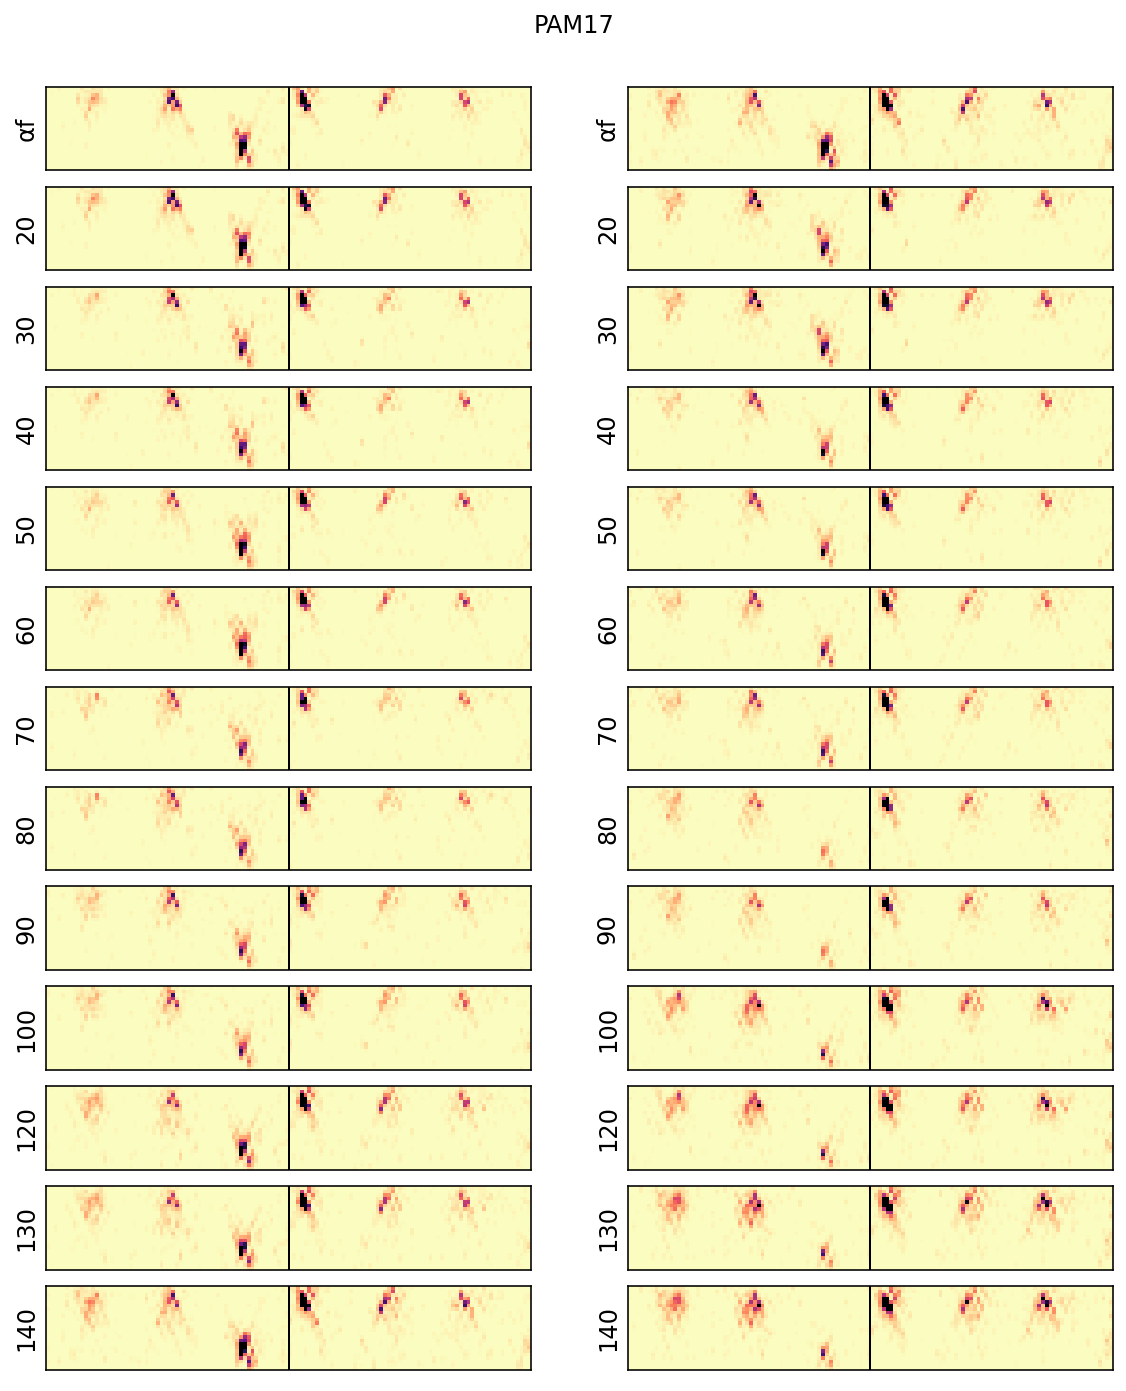

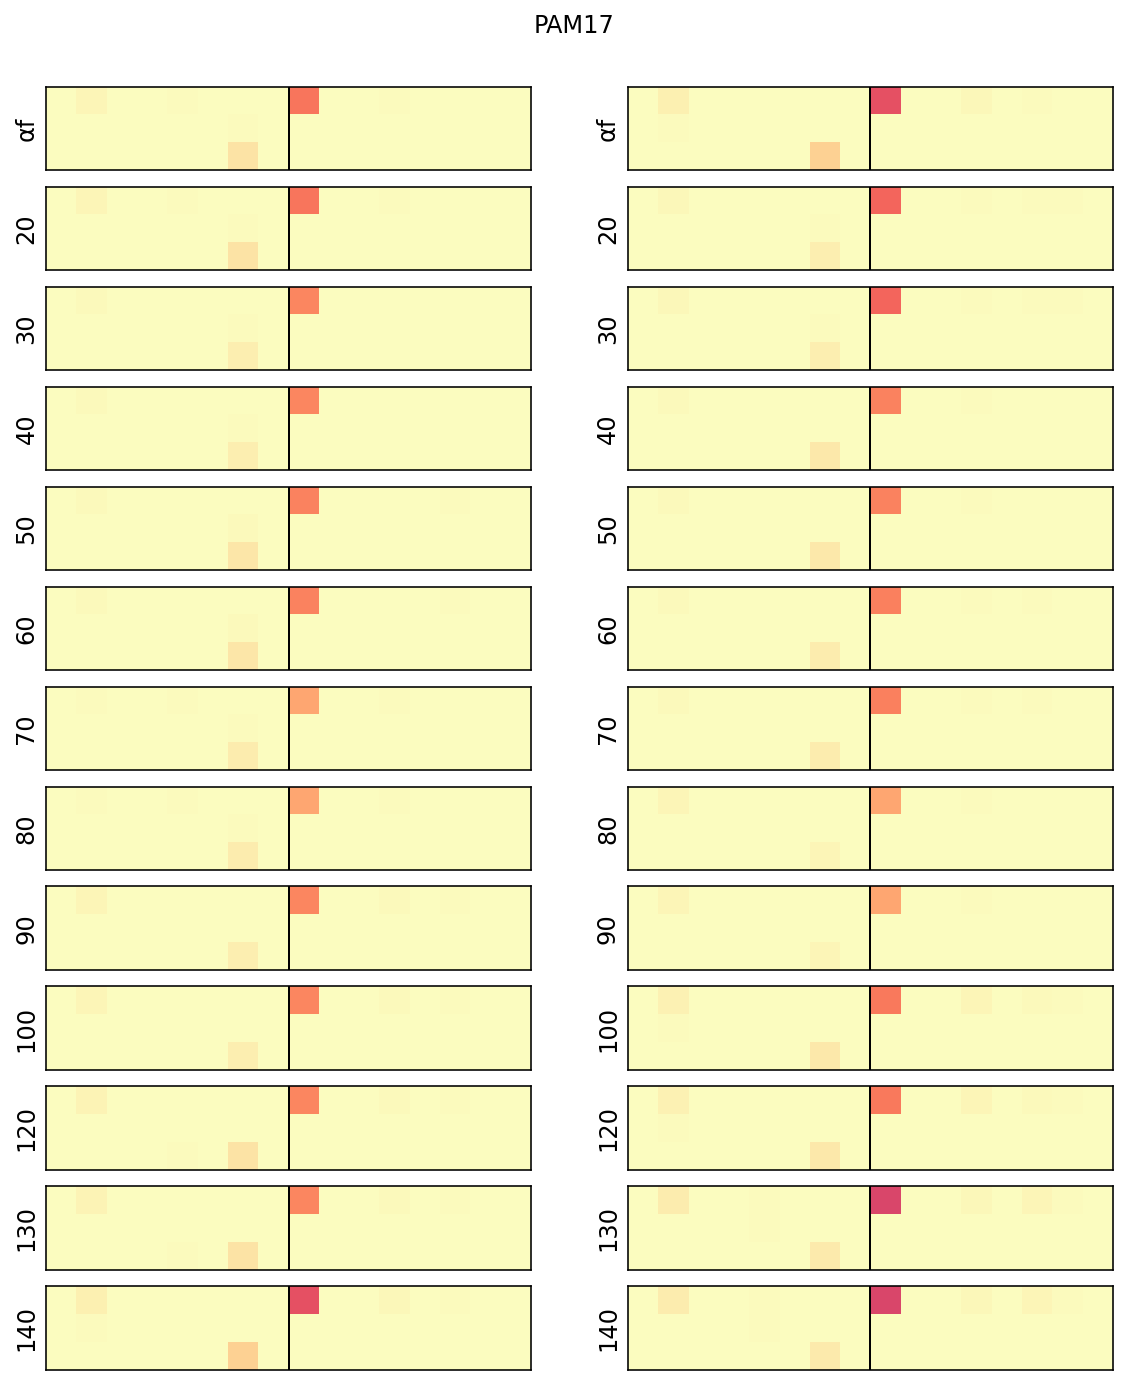

In [54]:
from src.attention_analysis import plot_typhoon
genes = ['PAM17']

for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, pivoted_images, vmin=-1, vmax=0.5)
    
for gene in genes:
    idx = vit_data.index_for(gene, 0.0)
    plot_typhoon(idx, vit_data, times, resize_pivoted, vmin=-1, vmax=10)
    

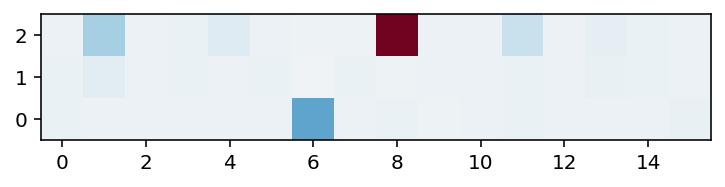

In [55]:
plt.imshow(fourier_scores[idx, 0, 0], cmap='RdBu_r', origin='lower', vmin=0, vmax=3)

In [56]:
fourier_scores.shape

(4427, 2, 2, 3, 16)

In [57]:
def plot_fourier_scores_summary(fourier_scores):
    fig = plt.figure(figsize=(22, 4))
    fig.tight_layout(rect=[0.0, 0., 1.0, 0.8])
    plt.subplots_adjust(hspace=0.75, wspace=0.25)

    plt.subplot(2, 1, 1)
    plt.imshow(fourier_scores[:, 0].mean(axis=0)[0], cmap='RdBu_r', origin='lower', vmin=1, 
               vmax=1.799, extent=[-512, 512, 0, 250])
    plt.axvline(0, c='black', lw=1)
    plt.colorbar()
    plt.title("Chromatin Fourier\nScore Mean")

    plt.subplot(2, 1, 2)
    plt.imshow(fourier_scores[:, 0].std(axis=0)[0], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 250],
              vmin=0, vmax=0.5)
    plt.axvline(0, c='white', lw=1)
    plt.colorbar()
    plt.title("Chromatin Fourier Score\nStandard Deviation")


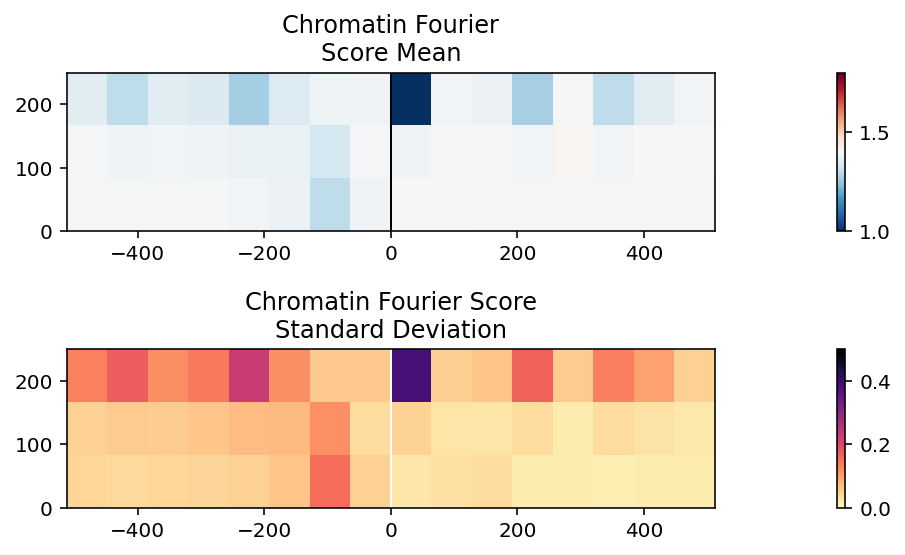

In [58]:
plot_fourier_scores_summary(fourier_scores)

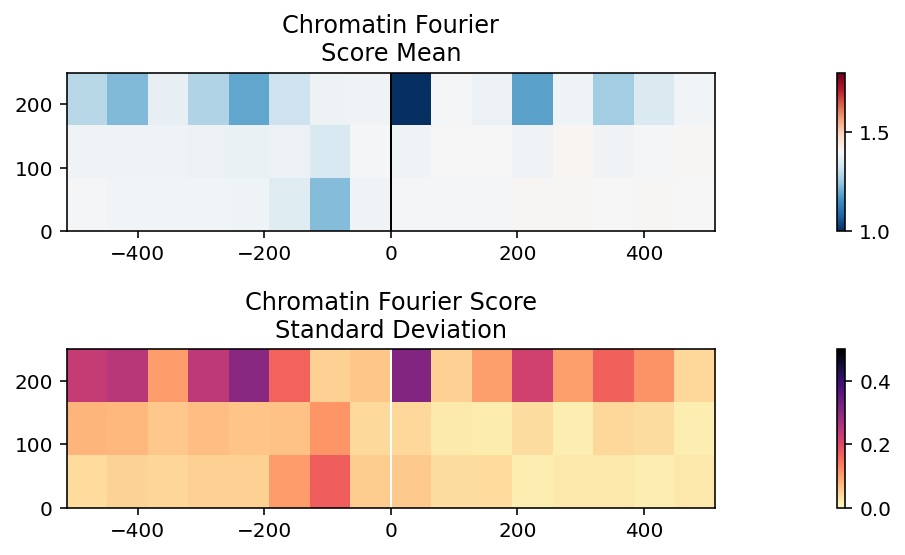

In [59]:
plot_fourier_scores_summary(fourier_scores[non_cell_cycling_genes.idx.values[-100:]])

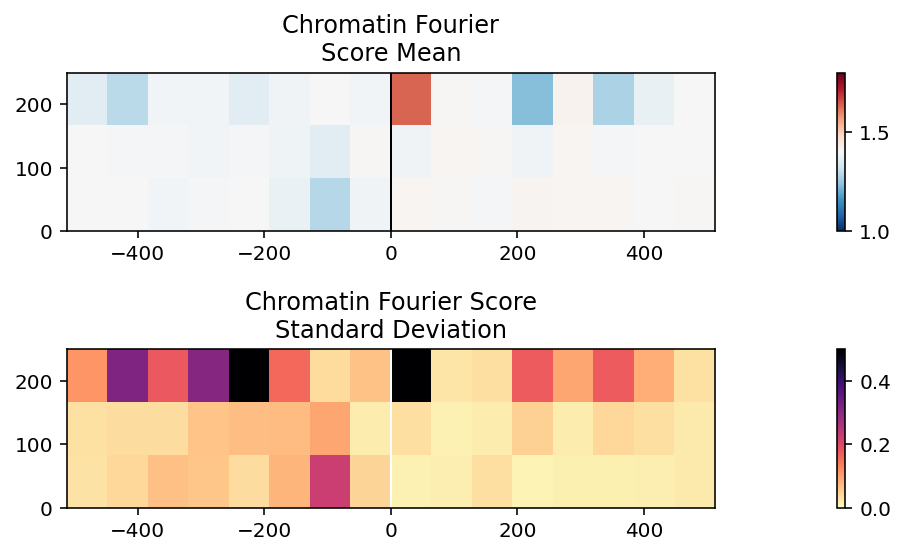

In [60]:
plot_fourier_scores_summary(fourier_scores[cell_cycling_genes.idx.values[:100]])